## Задание 1

[kaggle task](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)

Есть датасет с характеристиками покупателей в магазине.
<br>
Требуется разбить покупателей на k кластеров (выбор k остается за тобой), посчитать силуэт и визуализировать полученные кластеры

Выбор k должен быть обоснован, применять можно абсолютно любые алгоритмы.

**Заметка**: можно генерировать новые признаки и/или не использовать все имеющиеся, да и вообще делать все, что угодно и не противоречит здравому смыслу :)

**Не забывай фиксировать random_state для воспроизводимости результатов, где это требуется**

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

#from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score

from pathlib import Path

##other libraries on need##
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform

SEED = 42

In [2]:
df = pd.read_csv(Path('..', 'data', 'mall_customers.csv'))
print(df.shape)
df.head()

(200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None
CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64


In [4]:
# Предобработка признаков
categorical = ['Gender']
df = pd.concat([df, pd.get_dummies(df[categorical], columns=categorical, drop_first=True)],axis=1)
df.drop(categorical, axis=1, inplace=True)
df=df.drop('CustomerID',axis=1)

In [5]:
df.head()

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male
0,19,15,39,1
1,21,15,81,1
2,20,16,6,0
3,23,16,77,0
4,31,17,40,0


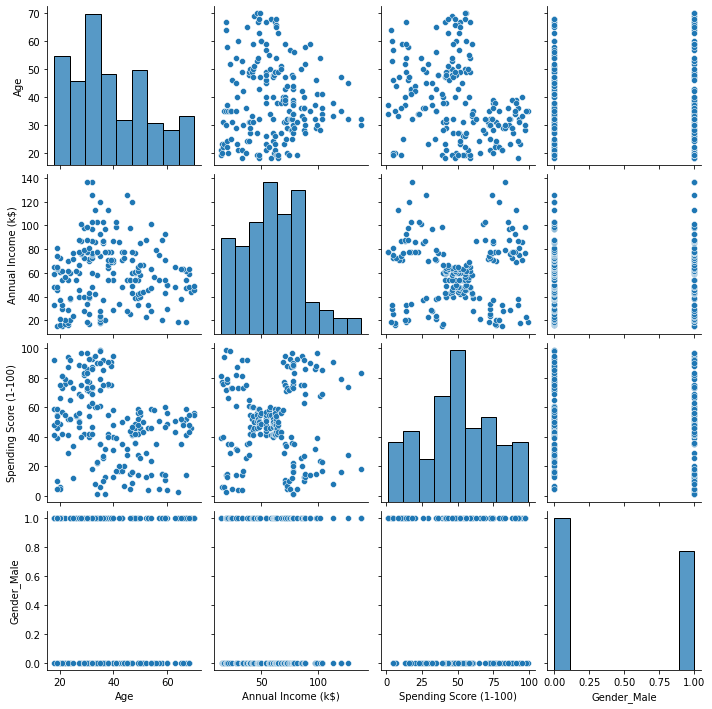

In [6]:
sns.pairplot(df)

<AxesSubplot:>

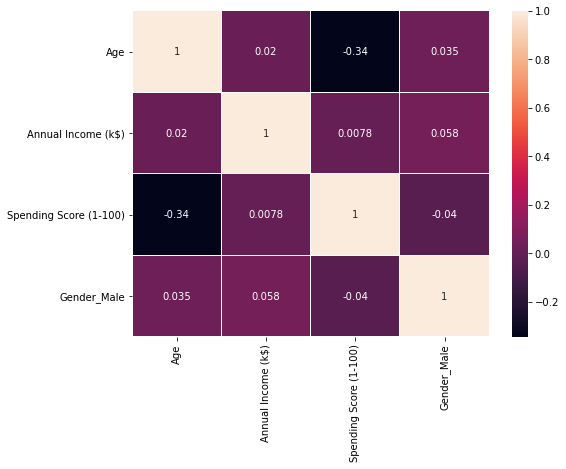

In [7]:
corr=df.corr(method='spearman')
f, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr,annot=True, linewidths=.1)
# Наблюдается корреляция между возрастом и расходами (Spending score)

In [8]:
def plot_dendrogram(model, **kwargs):
    '''Create linkage matrix and then plot the dendrogram
    create the counts of samples under each node
    '''
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
# Перед тем как начинать кластеризацию нужно проверить наличие кластерной структуры. 
# Для этого можно построить график 
# расстояния, на котором происходит слияние, от номера итерации при агломеративной иерархической кластеризации.

In [9]:
# Агломеративный подход: изначально каждый объект есть кластер, дальше происходит их слияние
agclust = AgglomerativeClustering(n_clusters=None, distance_threshold=1).fit(df)

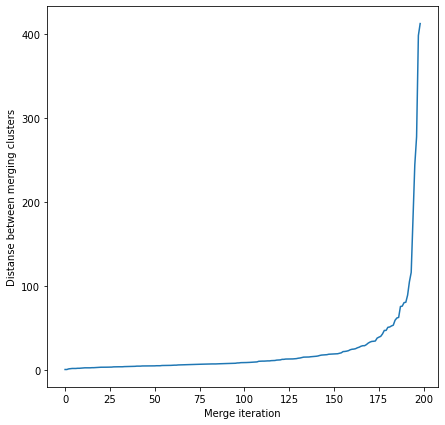

In [10]:
plt.figure(figsize=(7,7))
plt.ylabel('Distanse between merging clusters')
plt.xlabel('Merge iteration')
plt.plot(list(range(len(agclust.distances_))), agclust.distances_);

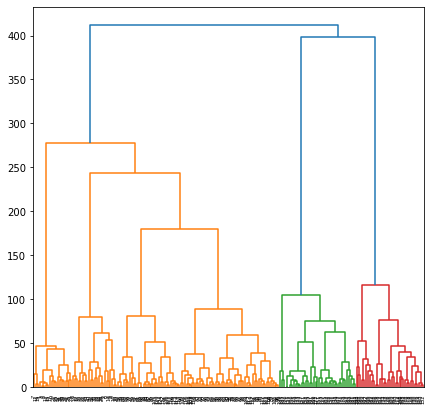

In [11]:
plt.figure(figsize=(7, 7))
plot_dendrogram(agclust)
# Чтобы определить число кластеров, можно посмотреть на дендрограмму.
# По ней видно, что можно имеет смысл рассмотреть 5 или 6 кластеров.

In [13]:
# Но дендрограмма это слишком визуально, поэтому можно построить кривую для коэффициента силуэта
def plot_silhouette_score_agl(df):
    silhouette_sc = []
    for k in range(2, 10):
        agl = AgglomerativeClustering(n_clusters=k).fit(df)
        yhat_agl = agl.labels_
        silhouette_sc.append(silhouette_score(df, yhat_agl))
        print(f'k = {k} silh = ', round(silhouette_sc[k-2],4) )
    
    
    plt.plot(range(2, 10), silhouette_sc, marker='s');
    plt.xlabel('$k$')
    plt.ylabel('$\Phi_0$')

k = 2 silh =  0.2992
k = 3 silh =  0.3813
k = 4 silh =  0.4102
k = 5 silh =  0.44
k = 6 silh =  0.4428
k = 7 silh =  0.4259
k = 8 silh =  0.4223
k = 9 silh =  0.3777


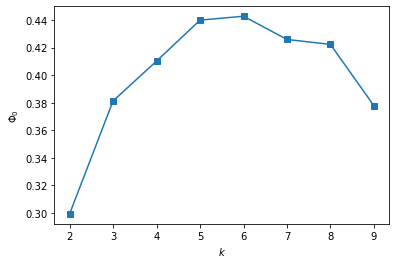

In [14]:
plot_silhouette_score_agl(df)
# По этой криаой можно увидеть, что самое большое значение на 5 и 6 кластерах.
# Чем ближе силуэт к 1, тем более четко выражены кластеры.

In [30]:
# Тогда посмотрим, что получится для 6 кластеров.
# Добавим в датасет информацию о кластерах.

agclust5 = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
cluster = agclust5.fit_predict(df)

yhat_agclust5 = agclust5.labels_

DFclaster = df.copy()
DFclaster['label_agclust'] = cluster

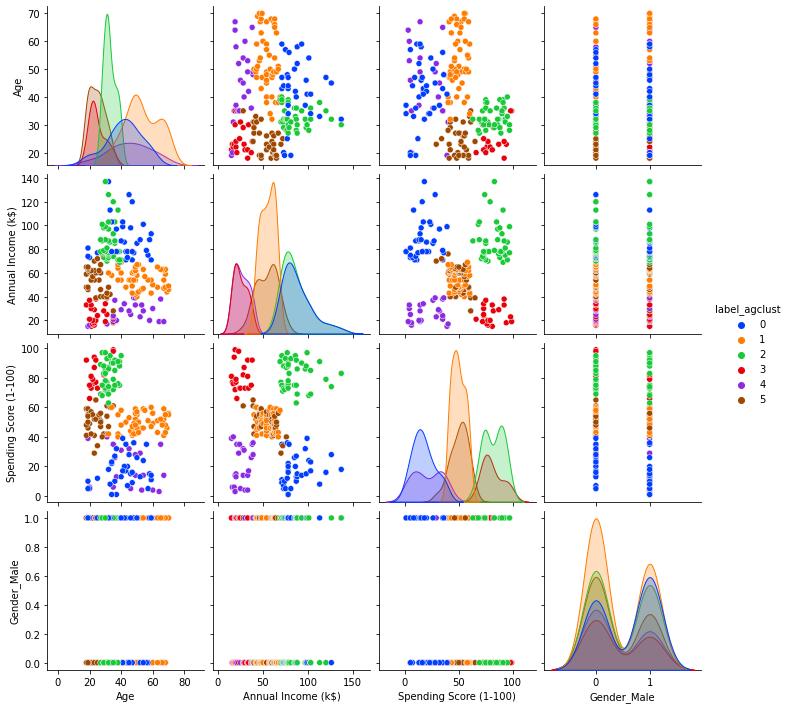

In [31]:
sns.pairplot(DFclaster[list(df)+['label_agclust']], hue='label_agclust', palette='bright')

In [17]:
# По этим графикам можно оценить характеристики кластеров.
# Гендер особого влияния не имеет.

In [32]:
# 0 - Высокий доход и низкие расходы
DFclaster[DFclaster['label_agclust']==0].describe().head(3)

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,label_agclust
count,35.000000,35.000000,35.000000,35.000000,35.0
mean,41.685714,88.228571,17.285714,0.571429,0.0
std,10.897305,16.367266,10.211215,0.502096,0.0


In [33]:
# 1 - Срений доход и средние расходы, средний возраст 53
DFclaster[DFclaster['label_agclust']==1].describe().head(3)

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,label_agclust
count,51.000000,51.000000,51.000000,51.000000,51.0
mean,53.215686,55.117647,49.470588,0.411765,1.0
std,10.461957,7.981596,6.070759,0.497050,0.0


In [34]:
# 2 - высокий доход и высокие расходы, возраст от 25 до 30 лет, средний возраст 32
DFclaster[DFclaster['label_agclust']==2].describe().head(3)

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,label_agclust
count,39.000000,39.000000,39.000000,39.000000,39.0
mean,32.692308,86.538462,82.128205,0.461538,2.0
std,3.728650,16.312485,9.364489,0.505035,0.0


In [35]:
# 3 - низкий доход и высокие расходы, возраст до 25 лет
DFclaster[DFclaster['label_agclust']==3].describe().head(3)

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,label_agclust
count,20.000000,20.000000,20.000000,20.000000,20.0
mean,24.850000,24.950000,81.000000,0.400000,3.0
std,5.029126,7.287155,9.514532,0.502625,0.0


In [36]:
# 4 - низкий доход и низкие расходы
DFclaster[DFclaster['label_agclust']==4].describe().head(3)

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,label_agclust
count,23.000000,23.000000,23.000000,23.000000,23.0
mean,45.217391,26.304348,20.913043,0.391304,4.0
std,13.228607,7.893811,13.017167,0.499011,0.0


In [37]:
# 5 - средний доход и средние расходы, возраст до 25 лет.
DFclaster[DFclaster['label_agclust']==5].describe().head(3)

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,label_agclust
count,32.000000,32.000000,32.00000,32.000000,32.0
mean,24.531250,54.187500,50.25000,0.375000,5.0
std,4.964288,11.663114,8.29691,0.491869,0.0


In [ ]:
# Таким образом, в качестве оптимального количества выбирается 6 кластеров.

In [23]:
# Можно попробовать другой способ кластеризации

In [24]:
def plot_inertia (df):
    inertia = []
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, random_state=SEED).fit(df)
        inertia.append(kmeans.inertia_)
    
    plt.plot(range(1, 10), inertia, marker='s');
    plt.xlabel('$k$')
    plt.ylabel('$\Phi_0$')

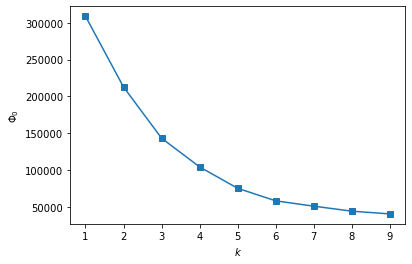

In [25]:
plot_inertia(df)
# В данном случае по инерции тяжело оценить оптимальное число кластеров

In [26]:
def plot_silhouette_score_kmeans(df):
    silhouette_sc = []
    for k in range(2, 10):
        kmeans = KMeans(n_clusters=k, random_state=SEED).fit(df)
        yhat_kmeans = kmeans.labels_
        silhouette_sc.append(silhouette_score(df, yhat_kmeans))
    
    m = max(silhouette_sc)
    print(f'k = { silhouette_sc.index(m)+2 } silh = ', m)
    
    plt.plot(range(2, 10), silhouette_sc, marker='s');
    plt.xlabel('$k$')
    plt.ylabel('$\Phi_0$')

k = 6 silh =  0.45205475380756527


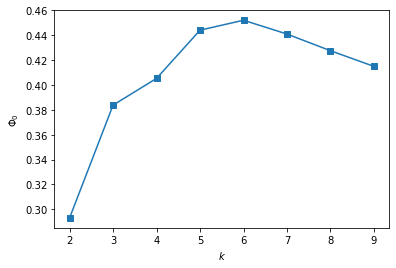

In [27]:
plot_silhouette_score_kmeans(df)
# Здесь коэффициент силуэта выше и более точно определяется оптимальное число кластеров.

In [28]:
kmeans = KMeans(n_clusters=6, n_jobs=-1, random_state=SEED).fit(df)
yhat_kmeans = kmeans.labels_
DFclaster['label_kmeans'] = yhat_kmeans

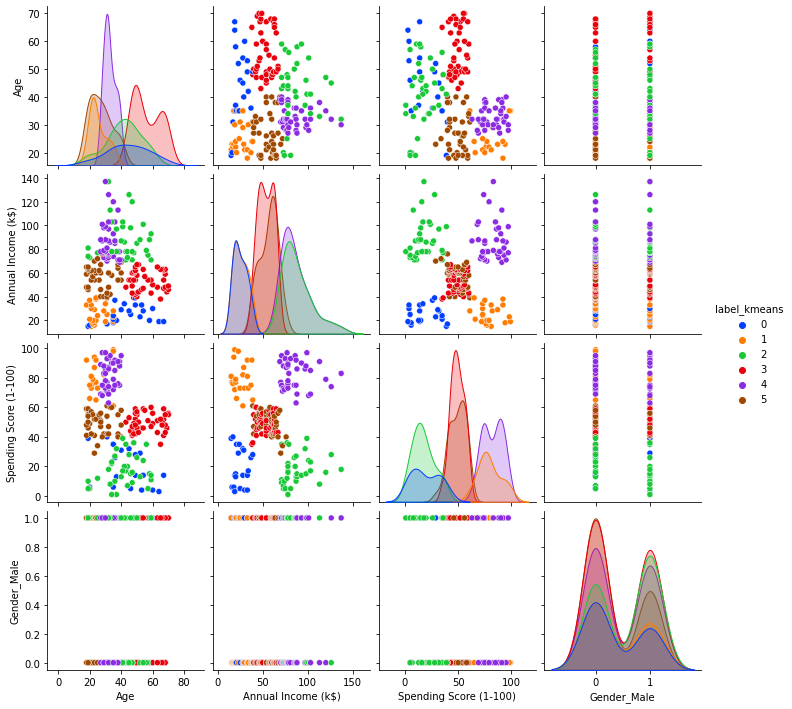

In [29]:
sns.pairplot(DFclaster[list(df)+['label_kmeans']], hue='label_kmeans', palette='bright')
# Результат получился аналогичным предыдущему алгоритму.
# Разделение на кластеры схожее.

In [38]:
DFclaster[DFclaster['label_agclust']==3].describe().head(3)

,Age,Annual Income (k$),Spending Score (1-100),Gender_Male,label_agclust
count,20.000000,20.000000,20.000000,20.000000,20.0
mean,24.850000,24.950000,81.000000,0.400000,3.0
std,5.029126,7.287155,9.514532,0.502625,0.0


In [48]:
def plot_silhouette_score_dbscan(df, min_s, l, r):
    silhouette_sc = []
    for k in range(l, r):
        dbscan = DBSCAN(eps=k, min_samples=min_s, n_jobs=-1).fit(df)
        yhat_dbscan = dbscan.labels_
        silhouette_sc.append(silhouette_score(df, yhat_dbscan))
    
    m = max(silhouette_sc)
    print(f'eps = { silhouette_sc.index(m)+l } silh = ', m)
    
    
    plt.plot(range(l, r), silhouette_sc, marker='s');
    plt.xlabel('$k$')
    plt.ylabel('$\Phi_0$')

eps = 22 silh =  0.39083611393057793


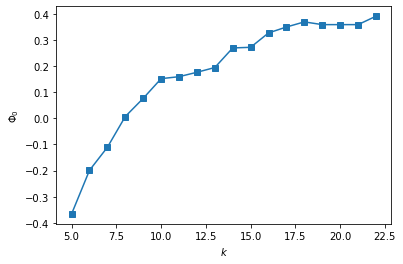

In [50]:
plot_silhouette_score_dbscan(df, 5, 5, 23)

In [42]:
dbscan = DBSCAN(eps=15, min_samples=5, n_jobs=-1).fit(df)
yhat_dbscan = dbscan.labels_

DFclaster['label_dbscan'] = yhat_dbscan

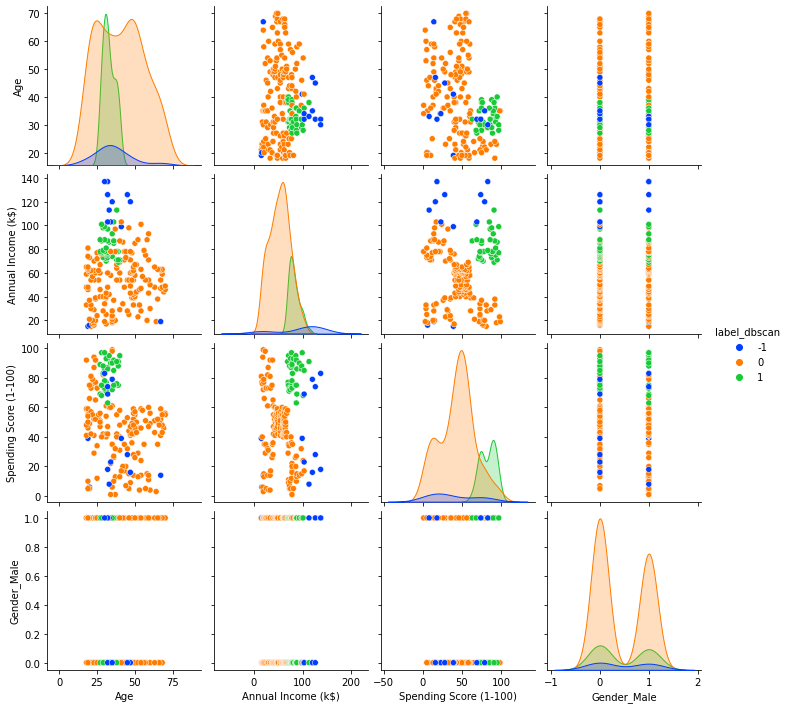

In [43]:
# Не так хорошо работает, как хотелось бы.
sns.pairplot(DFclaster[list(df)+['label_dbscan']], hue='label_dbscan',palette='bright')

In [44]:
dff = df.drop('Gender_Male', axis = 1).copy()

In [45]:
pca = PCA(n_components=2, random_state=42).fit(dff)
X_reduc = pca.transform(dff)

eps = 8 silh =  0.3612701647589505


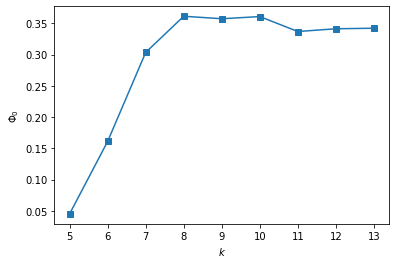

In [49]:
plot_silhouette_score_dbscan(X_reduc, 5, 5, 14)

In [51]:
dbscan2 = DBSCAN(eps=8, min_samples=5, n_jobs=-1).fit(X_reduc)
yhat_dbscan_2 = dbscan2.labels_

DFclaster['label_dbscan_2'] = yhat_dbscan_2

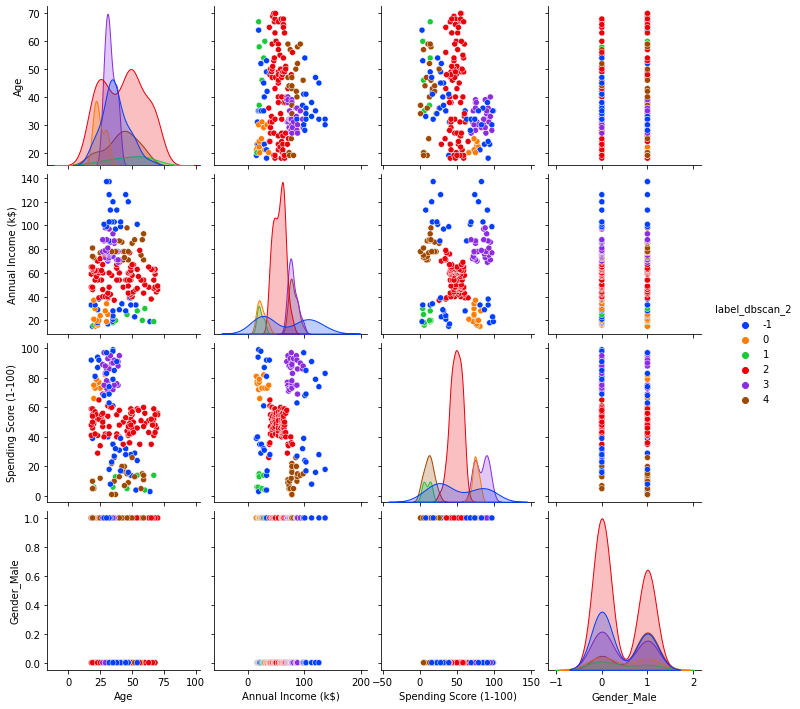

In [52]:
sns.pairplot(DFclaster[list(df)+['label_dbscan_2']], hue='label_dbscan_2',palette='bright')
# Это уже что-то более похожее на предыдущие алгоритмы, но все равно не так хорошо.

In [53]:
DFclaster['label_dbscan_2'].value_counts()

 2    88
-1    39
 3    30
 4    22
 0    13
 1     8
Name: label_dbscan_2, dtype: int64

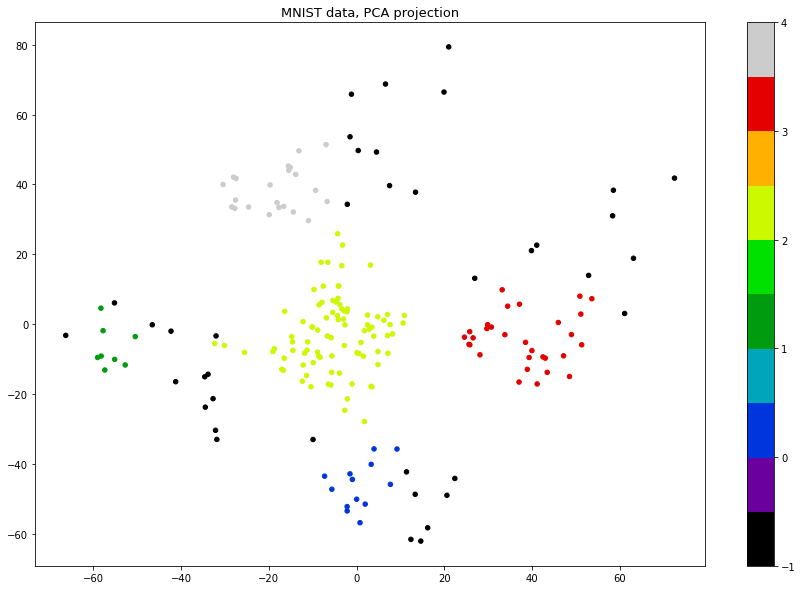

In [54]:
# Можно посмотреть как это выглядит по-другому
plt.figure(figsize=(15, 10))
plt.scatter(X_reduc[:, 0], X_reduc[:, 1], c=DFclaster['label_dbscan_2'], s=20, cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST data, PCA projection', fontsize=13);

In [44]:
def hopkins_statistics(X):
    '''Calculate hopkins statistics to check cluster stucture in data
    
    Parameters:
        X - numpy matrix
        
    Return:
        statistics
        
    Note:
        Estimation the clusterability of a dataset. A score between 0 and 1, a score around 0.5 express
        no clusterability and a score tending to 0 express a high cluster tendency
    '''
    n, d = X.shape[0], X.shape[1]
    m = int(0.1 * n) # heuristic from article
    
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
 
    rand_X = sample(range(n), m)
 
    ujd = []
    wjd = []
    for j in range(m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0), np.amax(X,axis=0), d).reshape(1, -1)
                                    , 2, return_distance=True)
        ujd.append(u_dist[0][1])
        
        w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(wjd) / (sum(ujd) + sum(wjd))
    
    return H

In [47]:
# Посчитаем статистику Хопкинса, чтобы оценить возможность кластеризации.
# Статистика не очень близка к нулю, возможно, это говорит о том, что в данном случае не стоит прибегать к 
# понижению размерности алгоритмом pca
print(f'Hopkins statistics: {hopkins_statistics(X_reduc)}')

Hopkins statistics: 0.2466488080252488


## Задание 2 (по желанию)

Возьмем стандартный датасет ирисов, состоящий из 4-х признаков длины/ширины внутренней и наружной долей околоцветника и таргета - вид цветка (kind).

1.Требуется кластеризовать цветки (да-да, количество кластеров уже известно), посчитать **accuracy**. Выбор алгоритма опять же на усмотрение (может быть несколько)
<br>
**Важно**: метки могут расставиться в другом порядке относительно истинного таргета, то есть после кластеризации будут получены 0, а это на самом деле 1, то есть надо сделать отображение $0 \rightarrow 1$ , то же самое касается и других меток. 
<br>
Поэтому, получив метки кластеров, стоит перебрать все возможные их перестановки. В этом поможет itertools.permutations

2.Воспользоваться любым/любыми пройденными/известными алгоритмами классификации и посчитать **accuracy** 
<br>
(Например, логистической регрессией)

In [1]:
from sklearn import datasets
import itertools

##other libraries on need##
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import seaborn as sns
from itertools import permutations
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
SEED = 42

In [2]:
df = datasets.load_iris()
df = pd.DataFrame(np.hstack([df['data'], df['target'].reshape(-1,1)])
             , columns=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'kind'])

print('Count of unique flowers', df['kind'].unique().shape[0])
df.head(10)

Count of unique flowers 3


,sepal_length,sepal_width,petal_length,petal_width,kind
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
5,5.4,3.9,1.7,0.4,0.0
6,4.6,3.4,1.4,0.3,0.0
7,5.0,3.4,1.5,0.2,0.0
8,4.4,2.9,1.4,0.2,0.0
9,4.9,3.1,1.5,0.1,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   kind          150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


### Кластеризация

In [5]:
def validate_with_mappings(y_true, y_pred):
    '''
    Check all possible permutations to maximize accuracy
    '''
    
    l = []
    permutations = itertools.permutations([0, 1, 2])
    for a, b, c in permutations:
        mapping = {0 : a, 1: b, 2: c}
        mapped_preds = [mapping[pred] for pred in y_pred]
        l.append((mapping, sum(mapped_preds == y_true) / len(y_true)))
                 
    return l

In [6]:
X = df.iloc[:, :-1]
y = df['kind']
##твой код с выбором алгоритма ##

In [7]:
agclust = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster = agclust.fit_predict(X)

DFclaster = X.copy()
DFclaster['label_agclust'] = cluster

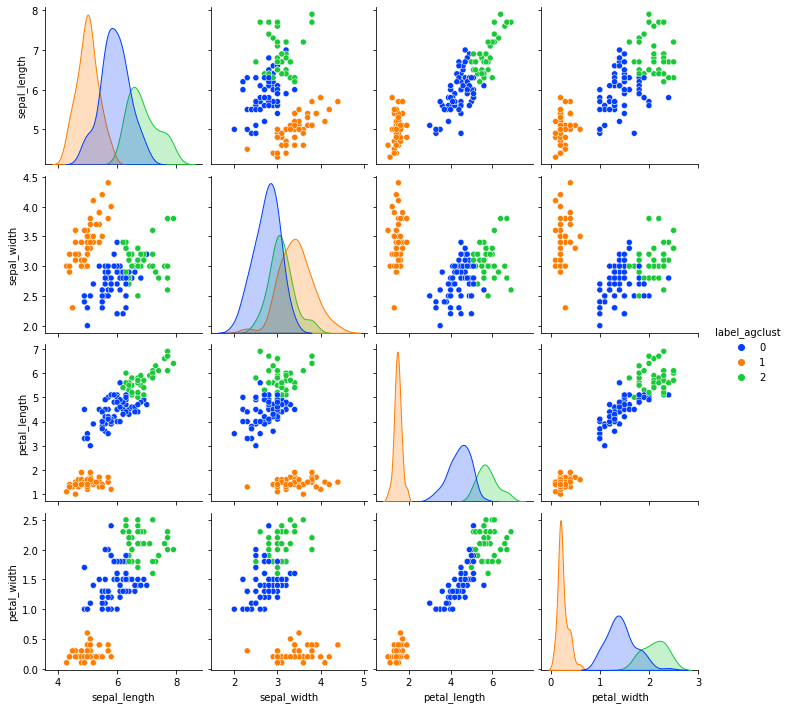

In [8]:
sns.pairplot(DFclaster[list(X)+['label_agclust']], hue='label_agclust', palette='bright')

In [23]:
def convert_to(y_pred):
    m = 0
    #m_item = 0
    for item in permutations((0, 1, 2)):
        a = np.array(y_pred-3)
        y_0 = (a==-3)
        y_1 = (a==-2)
        y_2 = (a==-1)
        np.putmask(a, y_0, item[0])
        np.putmask(a, y_1, item[1])
        np.putmask(a, y_2, item[2])
        
        ss = ((y == a)*1).sum()
        
        if m < ss:
            m = ss
            #item_m = item
            m_a = a
            
    return m_a

In [22]:
y_pred = DFclaster['label_agclust']
m_a = convert_to(y_pred)
print('accuracy = ', accuracy_score(y, m_a))
print(classification_report(y, m_a))
# Сначала не заметила функцию validate_with_mappings и написала convert_to, которая преобразовывает предсказание

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
145    2.0
146    2.0
147    2.0
148    2.0
149    2.0
Name: kind, Length: 150, dtype: float64
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
145    2.0
146    2.0
147    2.0
148    2.0
149    2.0
Name: kind, Length: 150, dtype: float64
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
145    2.0
146    2.0
147    2.0
148    2.0
149    2.0
Name: kind, Length: 150, dtype: float64
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
145    2.0
146    2.0
147    2.0
148    2.0
149    2.0
Name: kind, Length: 150, dtype: float64
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
145    2.0
146    2.0
147    2.0
148    2.0
149    2.0
Name: kind, Length: 150, dtype: float64
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
145    2.0
146    2.0
147    2.0
148    2.0
149    2.0
Name: kind, Length: 150, dtype: float64
accuracy =  0.8933333333333333
   

In [66]:
y_pred = DFclaster['label_agclust']
validate_with_mappings(y, y_pred)
# Здесь видимо нужно смотреть на максимум

[({0: 0, 1: 1, 2: 2}, 0.23333333333333334),
 ({0: 0, 1: 2, 2: 1}, 0.006666666666666667),
 ({0: 1, 1: 0, 2: 2}, 0.8933333333333333),
 ({0: 1, 1: 2, 2: 0}, 0.32666666666666666),
 ({0: 2, 1: 0, 2: 1}, 0.44),
 ({0: 2, 1: 1, 2: 0}, 0.1)]

In [67]:
kmeans = KMeans(n_clusters=3, random_state=SEED).fit(df)
yhat_kmeans = kmeans.labels_
DFclaster['label_kmeans'] = yhat_kmeans

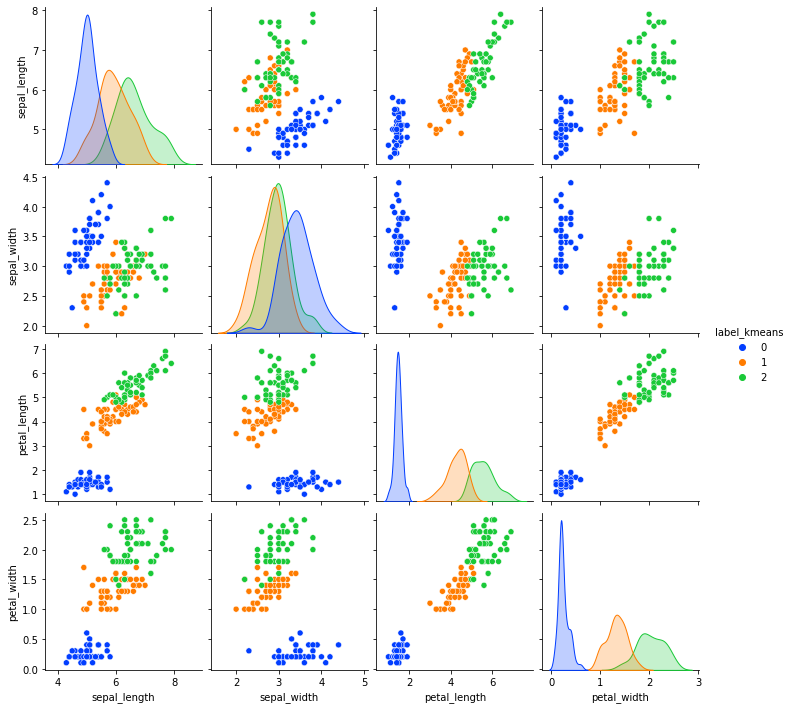

In [68]:
sns.pairplot(DFclaster[list(X)+['label_kmeans']], hue='label_kmeans', palette='bright')

In [82]:
y_pred = DFclaster['label_kmeans']
m_a = convert_to(y_pred)
print('accuracy = ', accuracy_score(y, m_a))
print(classification_report(y, m_a))

accuracy =  0.9933333333333333
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        50
         1.0       0.98      1.00      0.99        50
         2.0       1.00      0.98      0.99        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



In [70]:
y_pred = DFclaster['label_kmeans']
validate_with_mappings(y, y_pred)

[({0: 0, 1: 1, 2: 2}, 0.9933333333333333),
 ({0: 0, 1: 2, 2: 1}, 0.34),
 ({0: 1, 1: 0, 2: 2}, 0.32666666666666666),
 ({0: 1, 1: 2, 2: 0}, 0.006666666666666667),
 ({0: 2, 1: 0, 2: 1}, 0.0),
 ({0: 2, 1: 1, 2: 0}, 0.3333333333333333)]

### Классификация

In [85]:
##твой код##
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.5, shuffle=True,random_state=SEED)

In [90]:
# Метод опорных векторов
y_pred = SVC().fit(X_train, y_train).predict(X_test)


print('accuracy = ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy =  1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        29
         1.0       1.00      1.00      1.00        23
         2.0       1.00      1.00      1.00        23

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75



In [91]:
# k ближайших соседей
y_pred = KNeighborsClassifier().fit(X_train, y_train).predict(X_test)

print('accuracy = ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy =  0.9466666666666667
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        29
         1.0       0.85      1.00      0.92        23
         2.0       1.00      0.83      0.90        23

    accuracy                           0.95        75
   macro avg       0.95      0.94      0.94        75
weighted avg       0.95      0.95      0.95        75



**Вопрос**: что оказалось лучше: алгоритм классификации или кластеризации и на сколько?
<br>
**Ответ**: 
Наилучшим образом себя показал алгоритм клссификации методом опорных векторов, а текже метод кластеризации KMeans.  
При этом классификация методом k-ближайших соседей показывает себя хуже.  
Самое низкое значение accuracy получилось у агломеративной кластеризации.  
Таким образом, классификация методом опорных векторов в данном датасете лучше, но можно и кластеризацию KMeans.